# Stock Data Visualization Analysis
## XTB Stock Price and Volume Analysis

This notebook connects to the PostgreSQL database and analyzes XTB stock data from the test_stock_data schema.

In [10]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
from sqlalchemy import create_engine
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style for matplotlib
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [11]:
# Database connection parameters
DB_CONFIG = {
    'host': 'localhost',
    'port': '5432',
    'database': 'stock_data',
    'user': 'postgres',
    'password': 'postgres'
}

# Create both psycopg2 connection and SQLAlchemy engine
import psycopg2
connection_string = f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}"
engine = create_engine(connection_string)

# Create a raw psycopg2 connection for pandas
pg_conn = psycopg2.connect(
    host=DB_CONFIG['host'],
    port=DB_CONFIG['port'],
    database=DB_CONFIG['database'],
    user=DB_CONFIG['user'],
    password=DB_CONFIG['password']
)

print("Database connections established successfully!")

Database connections established successfully!


In [12]:
# Your SQL query for XTB stock visualization (corrected)
query = """
SELECT
    bi.symbol,
    bi.currency,
    sp.close_price,
    sp.volume,
    sp.trading_date_local
FROM
    test_stock_data.base_instruments AS bi
JOIN
    test_stock_data.stock_prices AS sp ON bi.id = sp.stock_id
WHERE
    bi.symbol = 'XTB'
ORDER BY
    sp.trading_date_local ASC;
"""

print("Executing your custom SQL query for XTB stock data...")

# Execute query and load data using psycopg2 connection
try:
    df = pd.read_sql_query(query, pg_conn)
    print(f"Data loaded successfully for XTB! Shape: {df.shape}")
    
    if not df.empty:
        print(f"Date range: {df['trading_date_local'].min()} to {df['trading_date_local'].max()}")
        print(f"Symbol: {df['symbol'].iloc[0]}")
        print(f"Currency: {df['currency'].iloc[0]}")
        print(f"Total records: {len(df)}")
        print("\nFirst few rows:")
        print(df.head())
        print("\nLast few rows:")
        print(df.tail())
    else:
        print("No data found for XTB stock")
        
except Exception as e:
    print(f"Error executing query: {e}")
    print("Trying to check available stocks first...")
    
    # Fallback - check what stocks are actually available
    try:
        check_query = """
        SELECT DISTINCT bi.symbol, COUNT(*) as record_count
        FROM test_stock_data.base_instruments bi
        JOIN test_stock_data.stock_prices sp ON bi.id = sp.stock_id
        GROUP BY bi.symbol
        ORDER BY bi.symbol;
        """
        available_df = pd.read_sql_query(check_query, pg_conn)
        print("Available stocks in database:")
        print(available_df)
        
        if not available_df.empty:
            # Use first available stock if XTB not found
            first_stock = available_df['symbol'].iloc[0]
            print(f"\nUsing {first_stock} instead of XTB...")
            
            fallback_query = f"""
            SELECT
                bi.symbol,
                bi.currency,
                sp.close_price,
                sp.volume,
                sp.trading_date_local
            FROM
                test_stock_data.base_instruments AS bi
            JOIN
                test_stock_data.stock_prices AS sp ON bi.id = sp.stock_id
            WHERE
                bi.symbol = '{first_stock}'
            ORDER BY
                sp.trading_date_local ASC;
            """
            
            df = pd.read_sql_query(fallback_query, pg_conn)
            print(f"Fallback data loaded for {first_stock}! Shape: {df.shape}")
            
            if not df.empty:
                print(f"Date range: {df['trading_date_local'].min()} to {df['trading_date_local'].max()}")
                print("\nFirst few rows:")
                print(df.head())
        else:
            df = pd.DataFrame()
            print("No stock data found in database")
            
    except Exception as e2:
        print(f"Fallback query also failed: {e2}")
        df = pd.DataFrame()

Executing your custom SQL query for XTB stock data...
Data loaded successfully for XTB! Shape: (2306, 5)
Date range: 2016-05-06 to 2025-08-19
Symbol: XTB
Currency: PLN
Total records: 2306

First few rows:
  symbol currency  close_price   volume trading_date_local
0    XTB      PLN      6.40241  2707543         2016-05-06
1    XTB      PLN      6.37555   582684         2016-05-09
2    XTB      PLN      6.34373    59439         2016-05-10
3    XTB      PLN      6.40241   325513         2016-05-11
4    XTB      PLN      6.45537   599581         2016-05-12

Last few rows:
     symbol currency  close_price  volume trading_date_local
2301    XTB      PLN        76.68  186982         2025-08-12
2302    XTB      PLN        76.22  194766         2025-08-13
2303    XTB      PLN        76.36  329883         2025-08-14
2304    XTB      PLN        77.20  167399         2025-08-18
2305    XTB      PLN        77.70   35542         2025-08-19


In [13]:
# Data overview and statistics
if not df.empty:
    print("Dataset Information:")
    print(f"Total records: {len(df)}")
    print(f"Date range: {df['trading_date_local'].min()} to {df['trading_date_local'].max()}")
    print(f"Currency: {df['currency'].iloc[0]}")
    print(f"Symbol: {df['symbol'].iloc[0]}")
    
    print("\nPrice and Volume Statistics:")
    price_volume_stats = df[['close_price', 'volume']].describe()
    print(price_volume_stats)
    
    # Convert trading_date_local to datetime if it's not already
    df['trading_date_local'] = pd.to_datetime(df['trading_date_local'])
    
    # Calculate additional metrics using available columns
    df['daily_return'] = df['close_price'].pct_change() * 100
    df['volume_ma_20'] = df['volume'].rolling(window=20).mean()
    df['close_ma_20'] = df['close_price'].rolling(window=20).mean()
    df['close_ma_50'] = df['close_price'].rolling(window=50).mean()
    
    # Since we don't have OHLC data, create price range estimates
    df['price_change'] = df['close_price'].diff()
    df['price_volatility'] = df['daily_return'].rolling(window=20).std()
    
    print(f"\nAdditional Calculated Metrics:")
    print(f"Average Daily Return: {df['daily_return'].mean():.3f}%")
    print(f"Return Volatility (20-day): {df['daily_return'].std():.3f}%")
    print(f"Price-Volume Correlation: {df['close_price'].corr(df['volume']):.3f}")
    
else:
    print("No data found for analysis.")

Dataset Information:
Total records: 2306
Date range: 2016-05-06 to 2025-08-19
Currency: PLN
Symbol: XTB

Price and Volume Statistics:
       close_price        volume
count  2306.000000  2.306000e+03
mean     19.078156  3.659201e+05
std      21.640040  7.404407e+05
min       1.747050  1.000000e+00
25%       3.162400  2.016375e+04
50%      10.528800  1.868710e+05
75%      26.903575  3.865535e+05
max      83.960300  1.186282e+07

Additional Calculated Metrics:
Average Daily Return: 0.159%
Return Volatility (20-day): 3.150%
Price-Volume Correlation: 0.078


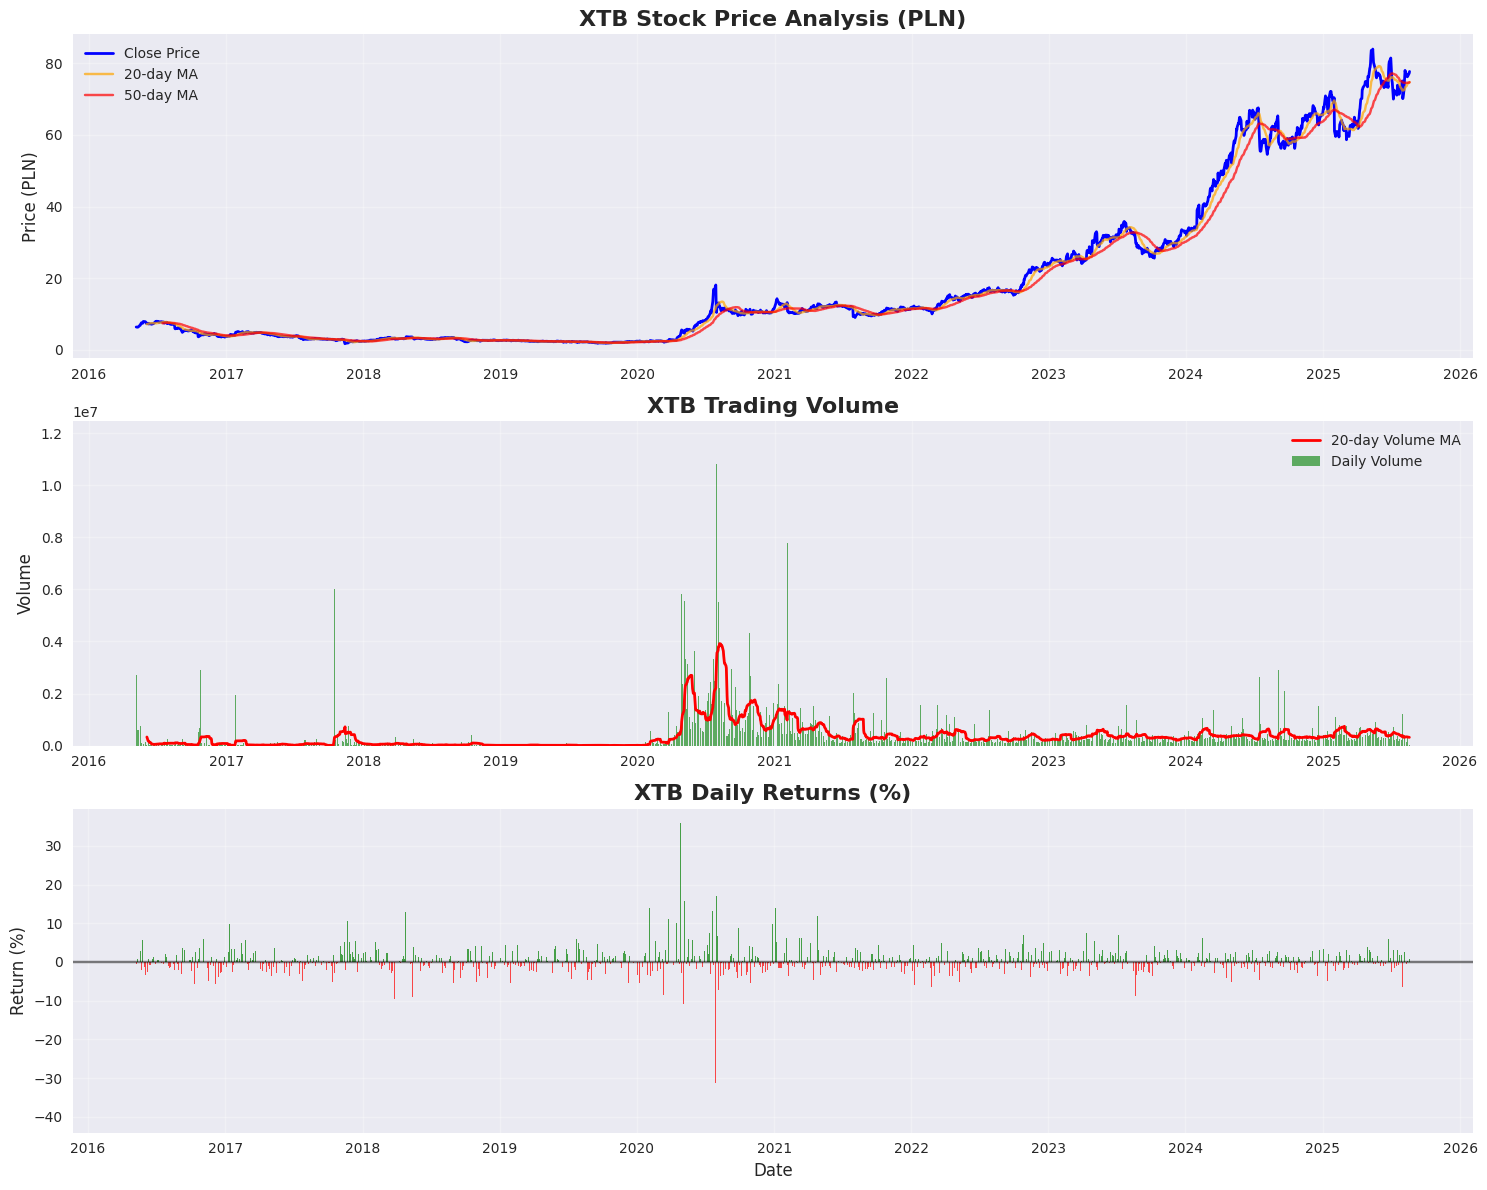


Key Metrics for XTB:
Current Price: 77.70 PLN
All-Time High: 83.96 PLN
All-Time Low: 1.75 PLN
Average Daily Volume: 365,920
Average Daily Return: 0.16%
Volatility (std of returns): 3.15%
Total Return: 1113.61%


In [14]:
# Create comprehensive stock price visualization with matplotlib
if not df.empty:
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    
    # Plot 1: Stock Price with Moving Averages (using close_price only)
    axes[0].plot(df['trading_date_local'], df['close_price'], label='Close Price', color='blue', linewidth=2)
    axes[0].plot(df['trading_date_local'], df['close_ma_20'], label='20-day MA', color='orange', alpha=0.7)
    axes[0].plot(df['trading_date_local'], df['close_ma_50'], label='50-day MA', color='red', alpha=0.7)
    
    axes[0].set_title(f'{df["symbol"].iloc[0]} Stock Price Analysis ({df["currency"].iloc[0]})', fontsize=16, fontweight='bold')
    axes[0].set_ylabel('Price (PLN)', fontsize=12)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Volume Analysis
    bars = axes[1].bar(df['trading_date_local'], df['volume'], alpha=0.6, color='green', label='Daily Volume', width=1)
    axes[1].plot(df['trading_date_local'], df['volume_ma_20'], color='red', linewidth=2, label='20-day Volume MA')
    axes[1].set_title(f'{df["symbol"].iloc[0]} Trading Volume', fontsize=16, fontweight='bold')
    axes[1].set_ylabel('Volume', fontsize=12)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Plot 3: Daily Returns
    colors = ['red' if x < 0 else 'green' for x in df['daily_return']]
    axes[2].bar(df['trading_date_local'], df['daily_return'], alpha=0.7, color=colors, width=1)
    axes[2].axhline(y=0, color='black', linestyle='-', alpha=0.5)
    axes[2].set_title(f'{df["symbol"].iloc[0]} Daily Returns (%)', fontsize=16, fontweight='bold')
    axes[2].set_ylabel('Return (%)', fontsize=12)
    axes[2].set_xlabel('Date', fontsize=12)
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print key metrics
    symbol = df['symbol'].iloc[0]
    currency = df['currency'].iloc[0]
    print(f"\nKey Metrics for {symbol}:")
    print(f"Current Price: {df['close_price'].iloc[-1]:.2f} {currency}")
    print(f"All-Time High: {df['close_price'].max():.2f} {currency}")
    print(f"All-Time Low: {df['close_price'].min():.2f} {currency}")
    print(f"Average Daily Volume: {df['volume'].mean():,.0f}")
    print(f"Average Daily Return: {df['daily_return'].mean():.2f}%")
    print(f"Volatility (std of returns): {df['daily_return'].std():.2f}%")
    print(f"Total Return: {((df['close_price'].iloc[-1] / df['close_price'].iloc[0]) - 1) * 100:.2f}%")
    
else:
    print("No data available for visualization.")

In [15]:
# Interactive Plotly visualization (adapted for close_price only data)
if not df.empty:
    # Create subplots
    fig = make_subplots(
        rows=3, cols=1,
        shared_xaxes=True,
        subplot_titles=(f'{df["symbol"].iloc[0]} Stock Price with Moving Averages', 'Trading Volume', 'Daily Returns'),
        vertical_spacing=0.08,
        row_heights=[0.5, 0.3, 0.2]
    )
    
    # Add close price line (since we don't have OHLC data)
    fig.add_trace(
        go.Scatter(
            x=df['trading_date_local'],
            y=df['close_price'],
            mode='lines',
            name='Close Price',
            line=dict(color='blue', width=2)
        ),
        row=1, col=1
    )
    
    # Add moving averages
    fig.add_trace(
        go.Scatter(
            x=df['trading_date_local'],
            y=df['close_ma_20'],
            mode='lines',
            name='20-day MA',
            line=dict(color='orange', width=2)
        ),
        row=1, col=1
    )
    
    fig.add_trace(
        go.Scatter(
            x=df['trading_date_local'],
            y=df['close_ma_50'],
            mode='lines',
            name='50-day MA',
            line=dict(color='red', width=2)
        ),
        row=1, col=1
    )
    
    # Add volume
    fig.add_trace(
        go.Bar(
            x=df['trading_date_local'],
            y=df['volume'],
            name='Volume',
            marker_color='lightblue',
            opacity=0.7
        ),
        row=2, col=1
    )
    
    # Add volume moving average
    fig.add_trace(
        go.Scatter(
            x=df['trading_date_local'],
            y=df['volume_ma_20'],
            mode='lines',
            name='20-day Volume MA',
            line=dict(color='red', width=2)
        ),
        row=2, col=1
    )
    
    # Add daily returns
    colors = ['red' if x < 0 else 'green' for x in df['daily_return']]
    fig.add_trace(
        go.Bar(
            x=df['trading_date_local'],
            y=df['daily_return'],
            name='Daily Returns',
            marker_color=colors,
            opacity=0.7
        ),
        row=3, col=1
    )
    
    # Update layout
    symbol = df['symbol'].iloc[0]
    currency = df['currency'].iloc[0]
    fig.update_layout(
        title=f'{symbol} Stock Analysis - Interactive Dashboard ({currency})',
        xaxis_title='Date',
        height=800,
        showlegend=True,
        template='plotly_white'
    )
    
    fig.update_yaxes(title_text=f'Price ({currency})', row=1, col=1)
    fig.update_yaxes(title_text='Volume', row=2, col=1)
    fig.update_yaxes(title_text='Return (%)', row=3, col=1)
    
    fig.show()
else:
    print("No data available for visualization.")

Price-Volume Correlation: 0.0778


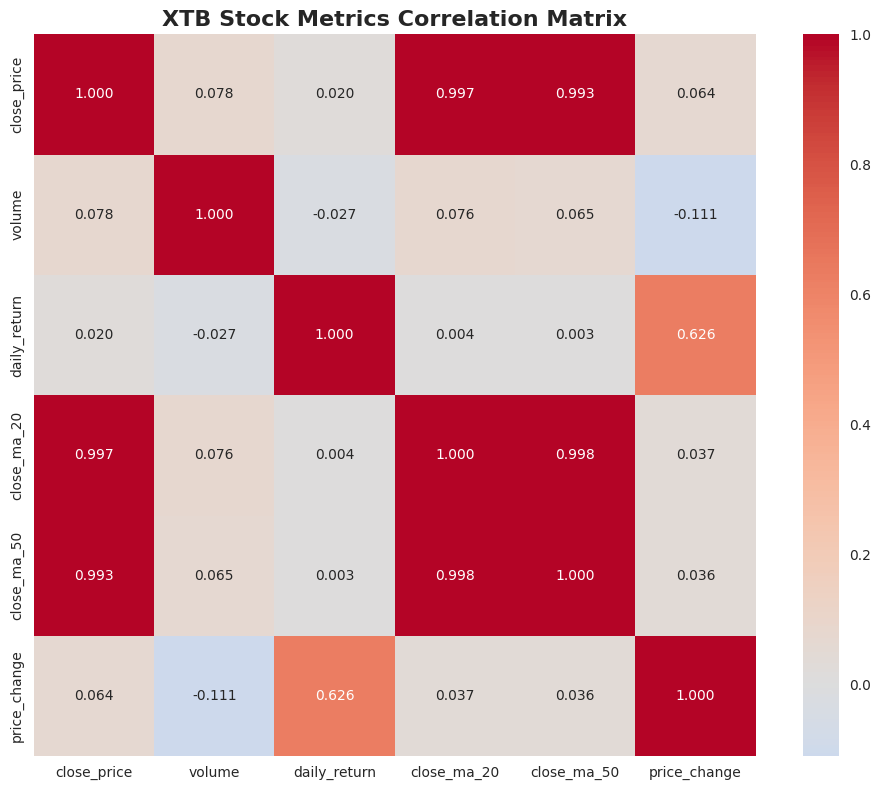

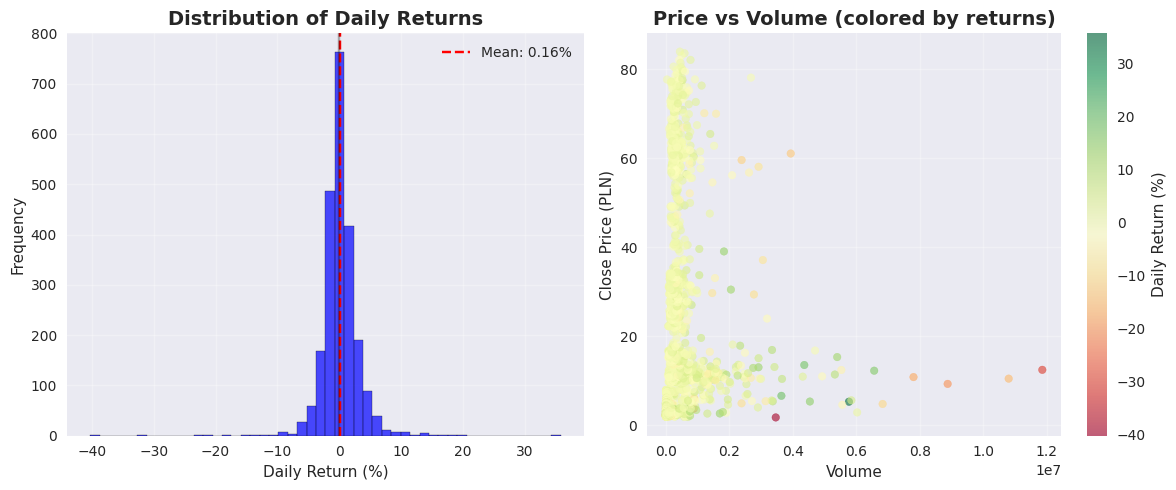


Detailed Statistics for XTB:
Data Period: 2306 trading days (2016-05-06 to 2025-08-19)
Price Range: 1.75 - 83.96 PLN
Volume Range: 1 - 11,862,815
Average Daily Volume: 365,920
Median Daily Volume: 186,871
Return Statistics:
  - Mean: 0.159%
  - Std Dev: 3.150%
  - Skewness: -0.567
  - Best Day: +35.78%
  - Worst Day: -40.26%


In [16]:
# Statistical analysis and correlation (adapted for simplified dataframe)
if not df.empty:
    # Price vs Volume correlation
    correlation = df['close_price'].corr(df['volume'])
    print(f"Price-Volume Correlation: {correlation:.4f}")
    
    # Create correlation matrix for available numerical columns
    numeric_cols = ['close_price', 'volume', 'daily_return', 'close_ma_20', 'close_ma_50', 'price_change']
    # Filter to only include columns that exist and have data
    available_numeric_cols = [col for col in numeric_cols if col in df.columns and df[col].notna().any()]
    
    if len(available_numeric_cols) >= 2:
        correlation_matrix = df[available_numeric_cols].corr()
        
        # Plot correlation heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                    square=True, fmt='.3f')
        plt.title(f'{df["symbol"].iloc[0]} Stock Metrics Correlation Matrix', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    # Distribution of daily returns and price-volume scatter
    plt.figure(figsize=(12, 5))
    
    # Return distribution
    plt.subplot(1, 2, 1)
    returns_clean = df['daily_return'].dropna()
    plt.hist(returns_clean, bins=50, alpha=0.7, color='blue', edgecolor='black')
    plt.axvline(returns_clean.mean(), color='red', linestyle='--', 
                label=f'Mean: {returns_clean.mean():.2f}%')
    plt.axvline(0, color='black', linestyle='-', alpha=0.3)
    plt.title('Distribution of Daily Returns', fontsize=14, fontweight='bold')
    plt.xlabel('Daily Return (%)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Price vs Volume scatter plot
    plt.subplot(1, 2, 2)
    scatter = plt.scatter(df['volume'], df['close_price'], 
                         alpha=0.6, c=df['daily_return'], 
                         cmap='RdYlGn', s=30)
    plt.colorbar(scatter, label='Daily Return (%)')
    plt.title('Price vs Volume (colored by returns)', fontsize=14, fontweight='bold')
    plt.xlabel('Volume')
    plt.ylabel(f'Close Price ({df["currency"].iloc[0]})')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Additional statistics
    print(f"\nDetailed Statistics for {df['symbol'].iloc[0]}:")
    print(f"Data Period: {len(df)} trading days ({df['trading_date_local'].min().date()} to {df['trading_date_local'].max().date()})")
    print(f"Price Range: {df['close_price'].min():.2f} - {df['close_price'].max():.2f} {df['currency'].iloc[0]}")
    print(f"Volume Range: {df['volume'].min():,} - {df['volume'].max():,}")
    print(f"Average Daily Volume: {df['volume'].mean():,.0f}")
    print(f"Median Daily Volume: {df['volume'].median():,.0f}")
    print(f"Return Statistics:")
    print(f"  - Mean: {returns_clean.mean():.3f}%")
    print(f"  - Std Dev: {returns_clean.std():.3f}%")
    print(f"  - Skewness: {returns_clean.skew():.3f}")
    print(f"  - Best Day: +{returns_clean.max():.2f}%")
    print(f"  - Worst Day: {returns_clean.min():.2f}%")
    
else:
    print("No data available for statistical analysis.")

Monthly Performance Summary (last 12 months):
            Open_Price  Close_Price  High_Price  Low_Price  Avg_Price  Avg_Volume  Total_Volume  Avg_Return  Return_Volatility  Min_Return  Max_Return  Monthly_Return
year_month                                                                                                                                                            
2024-09         65.325       57.115      65.325     56.184     58.223  604879.429      12702468      -0.488              2.422      -8.504       2.572          -12.57
2024-10         57.823       60.410      62.105     56.240     59.166  323145.174       7432339       0.268              2.241      -2.848       6.289            4.47
2024-11         62.607       65.921      65.921     61.807     64.616  304995.789       5794920       0.472              1.587      -2.474       3.636            5.29
2024-12         65.474       65.530      68.192     62.793     65.602  343106.278       6175913      -0.023            

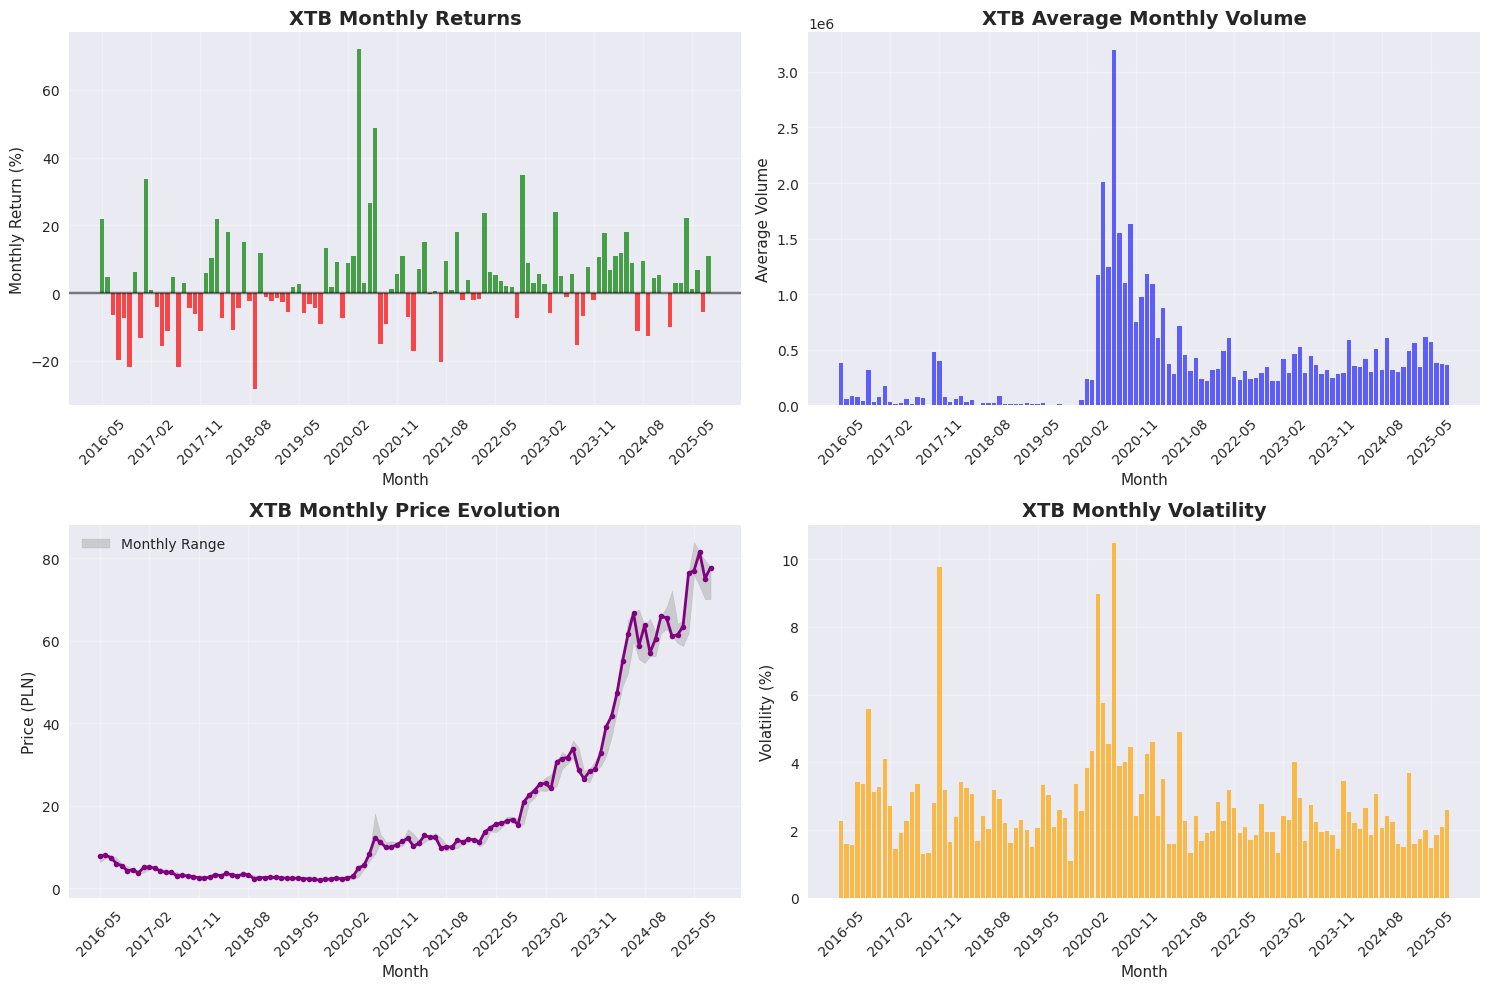


=== Monthly Performance Summary ===
Best Monthly Performance: 72.00% in 2020-04
Worst Monthly Performance: -28.19% in 2018-09
Average Monthly Return: 2.94%
Monthly Return Volatility: 13.95%
Positive Months: 66 / 112 (58.9%)


In [17]:
# Monthly aggregation analysis (adapted for simplified dataframe)
if not df.empty:
    # Create monthly aggregations
    df['year_month'] = df['trading_date_local'].dt.to_period('M')
    
    monthly_stats = df.groupby('year_month').agg({
        'close_price': ['first', 'last', 'max', 'min', 'mean'],
        'volume': ['mean', 'sum'],
        'daily_return': ['mean', 'std', 'min', 'max']
    }).round(3)
    
    # Flatten column names
    monthly_stats.columns = ['Open_Price', 'Close_Price', 'High_Price', 'Low_Price', 'Avg_Price', 
                            'Avg_Volume', 'Total_Volume', 'Avg_Return', 'Return_Volatility', 
                            'Min_Return', 'Max_Return']
    
    # Calculate monthly returns
    monthly_stats['Monthly_Return'] = ((monthly_stats['Close_Price'] - monthly_stats['Open_Price']) / monthly_stats['Open_Price'] * 100).round(2)
    
    print("Monthly Performance Summary (last 12 months):")
    print(monthly_stats.tail(12).to_string())
    
    # Plot monthly returns
    plt.figure(figsize=(15, 10))
    
    # Monthly returns bar chart
    plt.subplot(2, 2, 1)
    colors = ['red' if x < 0 else 'green' for x in monthly_stats['Monthly_Return']]
    bars = plt.bar(range(len(monthly_stats)), monthly_stats['Monthly_Return'], 
                   color=colors, alpha=0.7)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    plt.title(f'{df["symbol"].iloc[0]} Monthly Returns', fontsize=14, fontweight='bold')
    plt.ylabel('Monthly Return (%)')
    plt.xlabel('Month')
    
    # Show every 12th month label
    step = max(1, len(monthly_stats) // 12)
    plt.xticks(range(0, len(monthly_stats), step), 
               [str(monthly_stats.index[i]) for i in range(0, len(monthly_stats), step)], 
               rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Monthly volume
    plt.subplot(2, 2, 2)
    plt.bar(range(len(monthly_stats)), monthly_stats['Avg_Volume'], 
            color='blue', alpha=0.6)
    plt.title(f'{df["symbol"].iloc[0]} Average Monthly Volume', fontsize=14, fontweight='bold')
    plt.ylabel('Average Volume')
    plt.xlabel('Month')
    plt.xticks(range(0, len(monthly_stats), step), 
               [str(monthly_stats.index[i]) for i in range(0, len(monthly_stats), step)], 
               rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Price evolution
    plt.subplot(2, 2, 3)
    plt.plot(range(len(monthly_stats)), monthly_stats['Close_Price'], 
             marker='o', linewidth=2, markersize=4, color='purple')
    plt.fill_between(range(len(monthly_stats)), 
                     monthly_stats['Low_Price'], monthly_stats['High_Price'], 
                     alpha=0.3, color='gray', label='Monthly Range')
    plt.title(f'{df["symbol"].iloc[0]} Monthly Price Evolution', fontsize=14, fontweight='bold')
    plt.ylabel(f'Price ({df["currency"].iloc[0]})')
    plt.xlabel('Month')
    plt.xticks(range(0, len(monthly_stats), step), 
               [str(monthly_stats.index[i]) for i in range(0, len(monthly_stats), step)], 
               rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Monthly volatility
    plt.subplot(2, 2, 4)
    plt.bar(range(len(monthly_stats)), monthly_stats['Return_Volatility'], 
            color='orange', alpha=0.7)
    plt.title(f'{df["symbol"].iloc[0]} Monthly Volatility', fontsize=14, fontweight='bold')
    plt.ylabel('Volatility (%)')
    plt.xlabel('Month')
    plt.xticks(range(0, len(monthly_stats), step), 
               [str(monthly_stats.index[i]) for i in range(0, len(monthly_stats), step)], 
               rotation=45)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Performance summary
    best_month = monthly_stats['Monthly_Return'].idxmax()
    worst_month = monthly_stats['Monthly_Return'].idxmin()
    
    print(f"\n=== Monthly Performance Summary ===")
    print(f"Best Monthly Performance: {monthly_stats['Monthly_Return'].max():.2f}% in {best_month}")
    print(f"Worst Monthly Performance: {monthly_stats['Monthly_Return'].min():.2f}% in {worst_month}")
    print(f"Average Monthly Return: {monthly_stats['Monthly_Return'].mean():.2f}%")
    print(f"Monthly Return Volatility: {monthly_stats['Monthly_Return'].std():.2f}%")
    print(f"Positive Months: {(monthly_stats['Monthly_Return'] > 0).sum()} / {len(monthly_stats)} ({(monthly_stats['Monthly_Return'] > 0).mean()*100:.1f}%)")
    
else:
    print("No data available for monthly analysis.")

In [18]:
# Save results summary
if not df.empty:
    summary_stats = {
        'Symbol': df['symbol'].iloc[0],
        'Currency': df['currency'].iloc[0],
        'Analysis_Date': datetime.now().strftime('%Y-%m-%d'),
        'Data_Points': len(df),
        'Date_Range': f"{df['trading_date_local'].min().date()} to {df['trading_date_local'].max().date()}",
        'Current_Price': f"{df['close_price'].iloc[-1]:.2f}",
        'Highest_Close_Price': f"{df['close_price'].max():.2f}",
        'Lowest_Close_Price': f"{df['close_price'].min():.2f}",
        'Avg_Daily_Volume': f"{df['volume'].mean():,.0f}",
        'Avg_Daily_Return': f"{df['daily_return'].mean():.2f}%",
        'Return_Volatility': f"{df['daily_return'].std():.2f}%",
        'Price_Volume_Correlation': f"{df['close_price'].corr(df['volume']):.4f}",
        'Total_Return': f"{((df['close_price'].iloc[-1] / df['close_price'].iloc[0]) - 1) * 100:.2f}%"
    }
    
    print("\n=== Stock Analysis Summary ===")
    for key, value in summary_stats.items():
        print(f"{key.replace('_', ' ')}: {value}")
    
    # Additional performance metrics
    first_price = df['close_price'].iloc[0]
    last_price = df['close_price'].iloc[-1]
    years = (df['trading_date_local'].iloc[-1] - df['trading_date_local'].iloc[0]).days / 365.25
    annual_return = ((last_price / first_price) ** (1/years) - 1) * 100
    
    # CORRECTED Sharpe Ratio Calculation
    # Assume Polish government bond yield as risk-free rate (~4% for 2016-2025 period)
    risk_free_rate_annual = 0.04  # 4% annual risk-free rate
    daily_risk_free_rate = risk_free_rate_annual / 252  # 252 trading days per year
    
    # Convert daily returns from percentage to decimal and calculate excess returns
    daily_returns_decimal = df['daily_return'] / 100  # Convert from % to decimal
    excess_returns = daily_returns_decimal - daily_risk_free_rate
    
    # Calculate annualized Sharpe ratio
    if excess_returns.std() > 0:
        sharpe_ratio = (excess_returns.mean() / excess_returns.std()) * (252 ** 0.5)
    else:
        sharpe_ratio = 0
    
    # Alternative: using annualized values directly
    annualized_excess_return = annual_return / 100 - risk_free_rate_annual
    annualized_volatility = daily_returns_decimal.std() * (252 ** 0.5)
    sharpe_ratio_alt = annualized_excess_return / annualized_volatility if annualized_volatility > 0 else 0
    
    print(f"\n=== Performance Analysis ===")
    print(f"Investment Period: {years:.1f} years")
    print(f"Starting Price: {first_price:.2f} {df['currency'].iloc[0]}")
    print(f"Ending Price: {last_price:.2f} {df['currency'].iloc[0]}")
    print(f"Total Return: {((last_price/first_price - 1) * 100):.1f}%")
    print(f"Annualized Return: {annual_return:.1f}%")
    print(f"Annualized Volatility: {(annualized_volatility * 100):.1f}%")
    print(f"Risk-Free Rate (assumed): {risk_free_rate_annual * 100:.1f}%")
    print(f"Sharpe Ratio (corrected): {sharpe_ratio:.2f}")
    print(f"Sharpe Ratio (alternative): {sharpe_ratio_alt:.2f}")
    
    # Risk-Return Analysis
    print(f"\n=== Risk-Return Analysis ===")
    print(f"Excess Annual Return: {(annual_return - risk_free_rate_annual * 100):.1f}%")
    print(f"Return per Unit Risk: {(annual_return / (annualized_volatility * 100)):.2f}")
    print(f"Maximum Drawdown (approx): {((df['close_price'].min() / df['close_price'].max() - 1) * 100):.1f}%")
    
    # Export data for further analysis if data directory exists
    try:
        df.to_csv('../data/xtb_stock_analysis_data.csv', index=False)
        print(f"\n✅ Data exported to: ../data/xtb_stock_analysis_data.csv")
    except Exception as e:
        print(f"\n❌ Could not export data: {e}")
        
else:
    print("No data available for summary.")

# Close database connections
try:
    pg_conn.close()
    engine.dispose()
    print("\n🔌 Database connections closed successfully!")
except Exception as e:
    print(f"\n❌ Error closing connections: {e}")


=== Stock Analysis Summary ===
Symbol: XTB
Currency: PLN
Analysis Date: 2025-08-19
Data Points: 2306
Date Range: 2016-05-06 to 2025-08-19
Current Price: 77.70
Highest Close Price: 83.96
Lowest Close Price: 1.75
Avg Daily Volume: 365,920
Avg Daily Return: 0.16%
Return Volatility: 3.15%
Price Volume Correlation: 0.0778
Total Return: 1113.61%

=== Performance Analysis ===
Investment Period: 9.3 years
Starting Price: 6.40 PLN
Ending Price: 77.70 PLN
Total Return: 1113.6%
Annualized Return: 30.8%
Annualized Volatility: 50.0%
Risk-Free Rate (assumed): 4.0%
Sharpe Ratio (corrected): 0.72
Sharpe Ratio (alternative): 0.54

=== Risk-Return Analysis ===
Excess Annual Return: 26.8%
Return per Unit Risk: 0.62
Maximum Drawdown (approx): -97.9%

✅ Data exported to: ../data/xtb_stock_analysis_data.csv

🔌 Database connections closed successfully!
